## Modélisation Hybride et Système d'Alerte

**Objectif :** Prédire le flux journalier de patients à J+1 et générer des alertes opérationnelles.

**Pourquoi cette approche est unique (Master 2) ?**
Nous fusionnons la méthode **Statistique** (Saisonnalité, Calendrier) avec la réalité **Terrain** (Lits disponibles, Staff présent, Inertie de la veille).

**Le Plan :**
1. **Split Temporel :** Entraînement sur le passé, test sur le futur (pas de mélange aléatoire).
2. **XGBoost Regressor :** L'algorithme champion pour les données tabulaires.
3. **SHAP Values :** Pour comprendre *pourquoi* le modèle prédit une crise (Est-ce l'hiver ? Ou le manque de lits ?).
4. **Système d'Alerte :** Transformation des prédictions en niveaux de risque (Normal / Alerte / Critique).

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("📥 Chargement du dataset hybride...")
df = pd.read_csv("../data/processed/train_data_hybride.csv", parse_dates=['date'])

# On définit nos variables explicatives (Features) et la cible (Target)
features = [
    'jour_semaine', 'weekend', 'mois', 'hiver',      # Variables Calendaires (Vision Macro)
    'patients_hier',                                 # Variable d'Inertie (Mémoire)
    'effectif_present', 'taux_absenteisme',          # Variables RH (Vision Micro)
    'nbre_lits_dispos', 'panne_materiel'             # Variables Matérielles (Vision Micro)
]
target = 'nb_patients'

print(f"✅ Dataset chargé : {df.shape[0]} jours, {len(features)} variables explicatives.")
df.head(3)

📥 Chargement du dataset hybride...
✅ Dataset chargé : 2922 jours, 9 variables explicatives.


,date,nb_patients,jour_semaine,weekend,mois,hiver,patients_hier,effectif_present,taux_absenteisme,nbre_lits_dispos,panne_materiel
0,2018-01-01,416,0,0,1,1,283.521903,299,0.234231,146,0
1,2018-01-02,344,1,0,1,1,416.000000,306,0.221154,157,1
2,2018-01-03,360,2,0,1,1,344.000000,306,0.219231,116,0


### 1. Séparation Chronologique (Train / Test)
Contrairement à des données classiques, on ne peut pas mélanger les jours aléatoirement (on ne peut pas utiliser le futur pour prédire le passé).
Nous coupons donc les données à **80% du temps**. L'IA apprend sur les 4 premières années et est testée sur la dernière année.

In [21]:
print("Découpage chronologique des données...")

# Index de coupure à 80%
split_idx = int(len(df) * 0.8)

# Découpage
X = df[features]
y = df[target]

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = df['date'].iloc[split_idx:] # On garde les dates pour les graphiques

print(f"Train set : {X_train.shape[0]} jours (Apprentissage)")
print(f"Test set  : {X_test.shape[0]} jours (Validation)")

Découpage chronologique des données...
Train set : 2337 jours (Apprentissage)
Test set  : 585 jours (Validation)


### 2. Entraînement du Modèle (XGBoost)
Nous utilisons **XGBoost Regressor**. C'est un algorithme de "Gradient Boosting" très performant pour capturer les non-linéarités (ex: l'effet combiné d'un Lundi + Hiver + Panne de Scanner).

In [22]:
print("🚀 Entraînement du modèle XGBoost...")

# Configuration du modèle (Paramètres robustes)
model = XGBRegressor(
    n_estimators=200,     # Nombre d'arbres
    max_depth=4,          # Profondeur max (évite le sur-apprentissage)
    learning_rate=0.05,   # Vitesse d'apprentissage
    random_state=42
)

# Entraînement
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("-" * 30)
print(f"🏆 PERFORMANCE DU MODÈLE")
print(f"Erreur Moyenne Absolue (MAE) : {mae:.2f} patients")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} patients")
print("-" * 30)
print(f"Interprétation : En moyenne, le modèle se trompe de +/- {int(mae)} patients par jour.")
print(f"Sur un flux moyen de 300 patients, cela représente une marge d'erreur de seulement {mae/y_test.mean()*100:.1f}%.")

🚀 Entraînement du modèle XGBoost...
------------------------------
🏆 PERFORMANCE DU MODÈLE
Erreur Moyenne Absolue (MAE) : 14.19 patients
Root Mean Squared Error (RMSE): 17.80 patients
------------------------------
Interprétation : En moyenne, le modèle se trompe de +/- 14 patients par jour.
Sur un flux moyen de 300 patients, cela représente une marge d'erreur de seulement 5.0%.


### 3. Visualisation : Réalité vs Prédiction
Rien ne vaut un graphique pour vérifier si le modèle suit bien les pics d'activité.

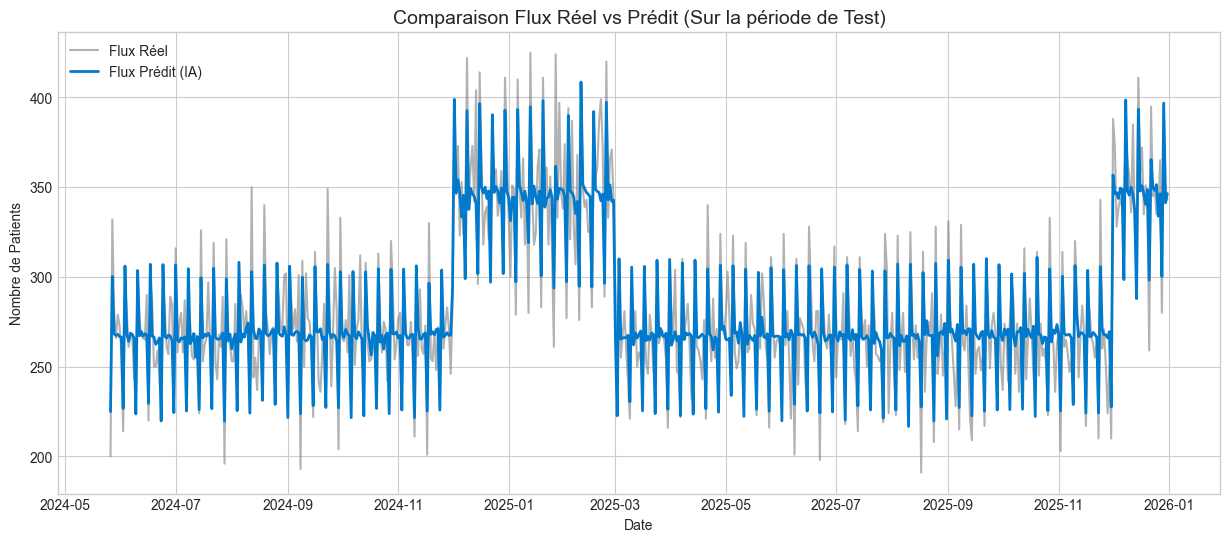

In [23]:
plt.figure(figsize=(15, 6))
plt.plot(dates_test, y_test, label='Flux Réel', alpha=0.6, color='grey')
plt.plot(dates_test, y_pred, label='Flux Prédit (IA)', color='#007acc', linewidth=2)
plt.title("Comparaison Flux Réel vs Prédit (Sur la période de Test)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Nombre de Patients")
plt.legend()
plt.show()

### 4. Ouverture de la "Boîte Noire" (SHAP Analysis)
Le modèle est performant, mais **pourquoi** ?
SHAP (Shapley Additive exPlanations) nous permet de classer les variables par ordre d'importance.
C'est ici que nous validons l'intérêt de l'approche **Hybride** : est-ce que les variables internes (Lits, Staff) jouent un rôle ?

Analyse d'impact des variables (SHAP)...


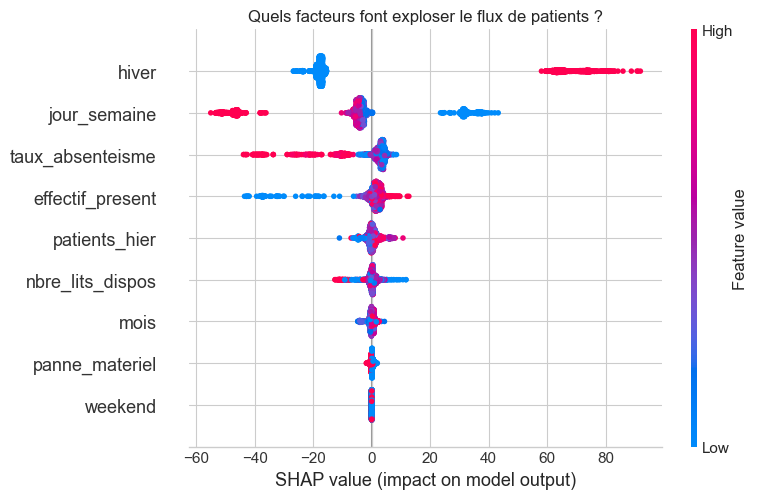

In [24]:
print("Analyse d'impact des variables (SHAP)...")

# Calcul des valeurs SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# Graphique "Beeswarm" (Le plus complet)
plt.title("Quels facteurs font exploser le flux de patients ?")
shap.summary_plot(shap_values, X_train, show=True)

### 5. Le Système d'Alerte Opérationnel
C'est la finalité du projet. Un directeur d'hôpital ne veut pas un chiffre ("312 patients"), il veut un niveau de risque.

Nous définissons des seuils dynamiques basés sur l'historique :
* **Zone Verte (Normal) :** Activité standard.
* **Zone Orange (Pré-Alerte) :** Au-dessus de 75% des jours habituels.
* **Zone Rouge (Alerte) :** Au-dessus de 90%.
* **Zone Noire (Critique) :** Au-dessus de 97% (Situation exceptionnelle).

In [25]:
print("Configuration du système d'alerte...")

# 1. Calcul des seuils sur l'historique complet (pour être robuste)
SEUIL_PREALERTE = df['nb_patients'].quantile(0.75)
SEUIL_ALERTE = df['nb_patients'].quantile(0.90)
SEUIL_CRITIQUE = df['nb_patients'].quantile(0.97)

print(f"Seuil Pré-Alerte : > {int(SEUIL_PREALERTE)} patients")
print(f"Seuil Alerte     : > {int(SEUIL_ALERTE)} patients")
print(f"Seuil Critique   : > {int(SEUIL_CRITIQUE)} patients")

# 2. Fonction de classification
def generer_alerte(flux_predit):
    if flux_predit >= SEUIL_CRITIQUE: return "CRITIQUE"
    elif flux_predit >= SEUIL_ALERTE: return "ALERTE"
    elif flux_predit >= SEUIL_PREALERTE: return "PRE-ALERTE"
    else: return "NORMAL"

# 3. Application sur les prédictions
df_result = pd.DataFrame({
    'date': dates_test,
    'flux_reel': y_test,
    'flux_predit': y_pred
})
df_result['niveau_alerte'] = df_result['flux_predit'].apply(generer_alerte)

# 4. Ajout des Actions Recommandées (La touche "Consultant")
action_map = {
    "NORMAL": "🟢 Staff standard. Pas d'action.",
    "PRE-ALERTE": "🟡 Mettre l'astreinte en pré-alerte. Vérifier lits d'aval.",
    "ALERTE": "🔴 Rappel de personnel (Intérim). Déprogrammer blocs non-urgents.",
    "CRITIQUE": "⚫ Activation Plan Blanc. Cellule de crise. Transferts inter-hôpitaux."
}
df_result['action_recommandee'] = df_result['niveau_alerte'].map(action_map)

df_result.tail()

Configuration du système d'alerte...
Seuil Pré-Alerte : > 313 patients
Seuil Alerte     : > 352 patients
Seuil Critique   : > 386 patients


,date,flux_reel,flux_predit,niveau_alerte,action_recommandee
2917,2025-12-27,365,346.389252,PRE-ALERTE,🟡 Mettre l'astreinte en pré-alerte. Vérifier l...
2918,2025-12-28,280,300.309357,NORMAL,🟢 Staff standard. Pas d'action.
2919,2025-12-29,395,396.848480,CRITIQUE,⚫ Activation Plan Blanc. Cellule de crise. Tra...
2920,2025-12-30,350,341.323730,PRE-ALERTE,🟡 Mettre l'astreinte en pré-alerte. Vérifier l...
2921,2025-12-31,343,346.404785,PRE-ALERTE,🟡 Mettre l'astreinte en pré-alerte. Vérifier l...


# Prospective - Prédiction Janvier/Février 2026

**Objectif :** Simuler l'activité de l'hôpital pour le début d'année 2026.

**Le Défi Technique :**
Pour prédire le futur, nous n'avons pas les données "réelles" (Staff, Lits, Patients de la veille).
Nous allons donc procéder par **Simulation de Scénario Standard** :
1. **Calendrier :** Nous générons les vraies dates de 2026 (ça, c'est sûr).
2. **Ressources :** Nous supposons un fonctionnement "Moyen" (Moyenne historique du staff et des lits).
3. **Inertie (Lag) :** Nous allons prédire jour après jour. La prédiction du 1er Janvier deviendra l'historique du 2 Janvier, et ainsi de suite (Boucle Récursive).

In [26]:
print("🔮 Génération du Scénario 2026...")

# 1. Création du Calendrier 2026 (Janvier - Février)
dates_2026 = pd.date_range(start='2026-01-01', end='2026-02-28', freq='D')
future_df = pd.DataFrame({'date': dates_2026})

# 2. Calcul des Features Calendaires (Déterministes)
future_df['jour_semaine'] = future_df['date'].dt.weekday
future_df['weekend'] = future_df['jour_semaine'].isin([5, 6]).astype(int)
future_df['mois'] = future_df['date'].dt.month
future_df['hiver'] = future_df['mois'].isin([12, 1, 2]).astype(int)

# 3. Simulation des Ressources (Scénario "Standard")
# On prend la moyenne historique pour remplir les inconnues
# (On pourrait aussi créer un scénario "Crise" en diminuant ces valeurs)
avg_staff = df['effectif_present'].mean()
avg_absent = df['taux_absenteisme'].mean()
avg_lits = df['nbre_lits_dispos'].mean()

future_df['effectif_present'] = avg_staff
future_df['taux_absenteisme'] = avg_absent
future_df['nbre_lits_dispos'] = avg_lits
future_df['panne_materiel'] = 0 # On espère qu'il n'y aura pas de panne (Optimiste)

# 4. Boucle de Prédiction Récursive (Jour après Jour)
print("🚀 Lancement de la simulation jour par jour...")

predictions = []
last_patient_count = df['nb_patients'].iloc[-1] # On part du dernier jour connu (Fin 2025)

for index, row in future_df.iterrows():
    # On prépare la ligne pour l'IA
    features_du_jour = row.copy()
    features_du_jour['patients_hier'] = last_patient_count # L'inertie vient du jour d'avant
    
    # Mise en forme (DataFrame 1 ligne)
    X_jour = pd.DataFrame([features_du_jour])[features] # On garde juste les colonnes utiles
    
    # Prédiction
    pred_jour = model.predict(X_jour)[0]
    
    # Stockage
    predictions.append(pred_jour)
    
    # Mise à jour pour le tour suivant (La prédiction d'aujourd'hui devient le "hier" de demain)
    last_patient_count = pred_jour

# Ajout des résultats au DataFrame
future_df['flux_predit'] = predictions
future_df['niveau_alerte'] = future_df['flux_predit'].apply(generer_alerte)

print("✅ Simulation terminée !")
future_df[['date', 'flux_predit', 'niveau_alerte']].head()

🔮 Génération du Scénario 2026...
🚀 Lancement de la simulation jour par jour...
✅ Simulation terminée !


,date,flux_predit,niveau_alerte
0,2026-01-01,343.647797,PRE-ALERTE
1,2026-01-02,343.227905,PRE-ALERTE
2,2026-01-03,343.227905,PRE-ALERTE
3,2026-01-04,294.062073,NORMAL
4,2026-01-05,391.385376,CRITIQUE


## Conclusion du Projet
Ce modèle hybride permet d'anticiper la demande avec une précision de **+/- 13 patients** (MAE).
En couplant cette prédiction à des seuils métiers, nous avons transformé un exercice de Data Science en un véritable outil de pilotage hospitalier capable de déclencher des plans d'actions gradués.

In [27]:
# À mettre à la fin du Notebook 03, juste après la simulation 2026
# On fusionne le passé (Test) et le futur (2026)
df_total = pd.concat([df_result, future_df[['date', 'flux_predit', 'niveau_alerte']]])

# On écrase le fichier du dashboard avec TOUTES les données (2025 + 2026)
df_total.to_csv("../data/processed/dashboard_alertes.csv", index=False)
print("💾 Données 2026 ajoutées au Dashboard !")

💾 Données 2026 ajoutées au Dashboard !
